In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, Lipinski
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def analyze_polymer_features_rdkit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {}
    
    # Basic molecular properties
    features['mol_weight'] = Descriptors.MolWt(mol)
    features['exact_mol_weight'] = Descriptors.ExactMolWt(mol)
    features['num_heavy_atoms'] = mol.GetNumHeavyAtoms()
    features['num_atoms'] = mol.GetNumAtoms()
    features['num_bonds'] = mol.GetNumBonds()
    
    # Hydrogen bonding features
    features['num_hbond_donors'] = Descriptors.NumHDonors(mol)
    features['num_hbond_acceptors'] = Descriptors.NumHAcceptors(mol)
    features['num_heteroatoms'] = Descriptors.NumHeteroatoms(mol)
    
    # Structural complexity
    features['num_rotatable_bonds'] = Descriptors.NumRotatableBonds(mol)
    features['num_saturated_rings'] = Descriptors.NumSaturatedRings(mol)
    features['num_aromatic_rings'] = Descriptors.NumAromaticRings(mol)
    features['num_aliphatic_rings'] = Descriptors.NumAliphaticRings(mol)
    features['ring_count'] = Descriptors.RingCount(mol)
    features['fraction_csp3'] = Descriptors.FractionCSP3(mol)
    
    # Surface area and polarity
    features['tpsa'] = Descriptors.TPSA(mol)
    features['polar_surface_area'] = rdMolDescriptors.CalcTPSA(mol)
    
    # Lipophilicity and solubility
    features['logp'] = Descriptors.MolLogP(mol)
    features['crippen_logp'] = Crippen.MolLogP(mol)
    features['crippen_mr'] = Crippen.MolMR(mol)  # Molar refractivity
    
    # Flexibility and rigidity
    features['kappa1'] = Descriptors.Kappa1(mol)  # Molecular shape index
    features['kappa2'] = Descriptors.Kappa2(mol)
    features['kappa3'] = Descriptors.Kappa3(mol)
    features['chi0v'] = Descriptors.Chi0v(mol)  # Connectivity indices
    features['chi1v'] = Descriptors.Chi1v(mol)
    features['chi2v'] = Descriptors.Chi2v(mol)
    
    # Electronic properties
    features['balaban_j'] = Descriptors.BalabanJ(mol)
    features['bertz_ct'] = Descriptors.BertzCT(mol)  # Complexity index
    
    # Polymer-specific features
    features['num_radical_electrons'] = Descriptors.NumRadicalElectrons(mol)
    features['num_valence_electrons'] = Descriptors.NumValenceElectrons(mol)
    
    # Atom type counts
    atom_counts = {}
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        atom_counts[symbol] = atom_counts.get(symbol, 0) + 1
    
    # Add individual atom counts as features
    for element in ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I']:
        features[f'count_{element}'] = atom_counts.get(element, 0)
        features[f'ratio_{element}'] = atom_counts.get(element, 0) / features['num_atoms'] if features['num_atoms'] > 0 else 0
    
    # Bond type analysis
    bond_types = {'SINGLE': 0, 'DOUBLE': 0, 'TRIPLE': 0, 'AROMATIC': 0}
    for bond in mol.GetBonds():
        bond_type = str(bond.GetBondType())
        if bond_type in bond_types:
            bond_types[bond_type] += 1
    
    for bond_type, count in bond_types.items():
        features[f'num_{bond_type.lower()}_bonds'] = count
        features[f'ratio_{bond_type.lower()}_bonds'] = count / features['num_bonds'] if features['num_bonds'] > 0 else 0
    
    # Hybridization analysis
    hybridization_counts = {'SP': 0, 'SP2': 0, 'SP3': 0, 'SP3D': 0, 'SP3D2': 0}
    for atom in mol.GetAtoms():
        hyb = str(atom.GetHybridization())
        if hyb in hybridization_counts:
            hybridization_counts[hyb] += 1
    
    for hyb_type, count in hybridization_counts.items():
        features[f'num_{hyb_type.lower()}_carbons'] = count
        features[f'ratio_{hyb_type.lower()}_carbons'] = count / features['num_atoms'] if features['num_atoms'] > 0 else 0
    
    # Formal charge analysis
    formal_charges = [atom.GetFormalCharge() for atom in mol.GetAtoms()]
    features['total_formal_charge'] = sum(formal_charges)
    features['abs_total_formal_charge'] = sum(abs(charge) for charge in formal_charges)
    features['max_formal_charge'] = max(formal_charges) if formal_charges else 0
    features['min_formal_charge'] = min(formal_charges) if formal_charges else 0
    
    # Aromaticity features
    aromatic_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic())
    features['num_aromatic_atoms'] = aromatic_atoms
    features['aromatic_ratio'] = aromatic_atoms / features['num_atoms'] if features['num_atoms'] > 0 else 0
    
    # Ring size analysis
    ring_info = mol.GetRingInfo()
    ring_sizes = [len(ring) for ring in ring_info.AtomRings()]
    if ring_sizes:
        features['avg_ring_size'] = sum(ring_sizes) / len(ring_sizes)
        features['max_ring_size'] = max(ring_sizes)
        features['min_ring_size'] = min(ring_sizes)
        features['num_3_rings'] = sum(1 for size in ring_sizes if size == 3)
        features['num_4_rings'] = sum(1 for size in ring_sizes if size == 4)
        features['num_5_rings'] = sum(1 for size in ring_sizes if size == 5)
        features['num_6_rings'] = sum(1 for size in ring_sizes if size == 6)
        features['num_7_rings'] = sum(1 for size in ring_sizes if size == 7)
        features['num_large_rings'] = sum(1 for size in ring_sizes if size > 7)
    else:
        features.update({
            'avg_ring_size': 0, 'max_ring_size': 0, 'min_ring_size': 0,
            'num_3_rings': 0, 'num_4_rings': 0, 'num_5_rings': 0,
            'num_6_rings': 0, 'num_7_rings': 0, 'num_large_rings': 0
        })
    
    # Polymer-specific structural features
    features['has_polymer_notation'] = '*' in smiles
    features['smiles_length'] = len(smiles)
    features['branch_count'] = smiles.count('(')
    features['branch_ratio'] = smiles.count('(') / len(smiles) if len(smiles) > 0 else 0
    
    return features

def add_features(df, num_workers=None):
    """
    Improved version using multiprocessing to calculate RDKit descriptors efficiently.
    
    Parameters:
    df: pandas DataFrame with 'Smiles' column
    num_workers: Number of worker processes (defaults to number of CPU cores)
    """
    if num_workers is None:
        num_workers = multiprocessing.cpu_count()
    
    smiles_list = df['Smiles'].tolist()
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        # Use tqdm with executor.map for progress tracking
        features_list = list(tqdm(executor.map(analyze_polymer_features_rdkit, smiles_list), 
                                total=len(smiles_list), 
                                desc="Computing RDKit descriptors"))
    
    # Convert results to DataFrame
    features_df = pd.DataFrame(features_list)
    
    # Concatenate with original DataFrame
    df_result = pd.concat([df, features_df], axis=1)
    
    return df_result

def get_list_dif(l1, l2):
    return list(set(l1) - set(l2))

# Usage example:
# df_with_features = add_features(df, num_workers=4)


In [ ]:
df = pd.read_csv('/home/jovyan/simson_training_bolgov/regression/PI_Tg_P308K_synth_db_chem.csv').drop(columns=['Unnamed: 0'], axis=1)

In [ ]:
df = pd.read_csv('/home/jovyan/simson_training_bolgov/kaggle_comp/train.csv')
df['Smiles'] = df['SMILES']
df

In [ ]:
sample_df = df.iloc[:10_000]

In [ ]:
features_df = add_features(sample_df)

In [2]:
selected_features = ['mol_weight', 'exact_mol_weight', 'num_heavy_atoms', 'num_atoms',
       'num_bonds', 'num_hbond_donors', 'num_hbond_acceptors',
       'num_heteroatoms', 'num_rotatable_bonds', 'num_saturated_rings',
       'num_aromatic_rings', 'num_aliphatic_rings', 'ring_count',
       'fraction_csp3', 'tpsa', 'polar_surface_area', 'logp', 'crippen_logp',
       'crippen_mr', 'kappa1', 'kappa2', 'kappa3', 'chi0v', 'chi1v', 'chi2v',
       'balaban_j', 'bertz_ct', 'num_radical_electrons',
       'num_valence_electrons',
       'count_O', 'ratio_O', 'count_S', 'ratio_S', 'count_P', 'ratio_P',
       'count_F', 'ratio_F', 'count_Cl', 'ratio_Cl', 'count_Br', 'ratio_Br',
       'count_I', 'ratio_I', 'num_single_bonds', 'ratio_single_bonds',
       'num_double_bonds', 'ratio_double_bonds', 'num_triple_bonds',
       'ratio_triple_bonds', 'num_aromatic_bonds', 'ratio_aromatic_bonds',
       'num_sp_carbons', 'ratio_sp_carbons', 'num_sp2_carbons',
       'ratio_sp2_carbons', 'num_sp3_carbons', 'ratio_sp3_carbons',
       'num_sp3d_carbons', 'ratio_sp3d_carbons', 'num_sp3d2_carbons',
       'ratio_sp3d2_carbons', 'total_formal_charge', 'abs_total_formal_charge',
       'max_formal_charge', 'min_formal_charge', 'num_aromatic_atoms',
       'aromatic_ratio', 'avg_ring_size', 'max_ring_size', 'min_ring_size',
       'num_3_rings', 'num_4_rings', 'num_5_rings', 'num_6_rings',
       'num_7_rings', 'num_large_rings', 'has_polymer_notation',
       'branch_count', 'branch_ratio']

In [4]:
scalers = []
for col in selected_features:
    scaler = StandardScaler()
    features_df[col] = scaler.fit_transform(features_df[col].to_numpy().reshape(-1, 1)).flatten()
    scalers.append(scaler)
    
features_df.columns

Index(['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg', 'Smiles',
       'mol_weight', 'exact_mol_weight', 'num_heavy_atoms', 'num_atoms',
       'num_bonds', 'num_hbond_donors', 'num_hbond_acceptors',
       'num_heteroatoms', 'num_rotatable_bonds', 'num_saturated_rings',
       'num_aromatic_rings', 'num_aliphatic_rings', 'ring_count',
       'fraction_csp3', 'tpsa', 'polar_surface_area', 'logp', 'crippen_logp',
       'crippen_mr', 'kappa1', 'kappa2', 'kappa3', 'chi0v', 'chi1v', 'chi2v',
       'balaban_j', 'bertz_ct', 'num_radical_electrons',
       'num_valence_electrons', 'count_C', 'ratio_C', 'count_N', 'ratio_N',
       'count_O', 'ratio_O', 'count_S', 'ratio_S', 'count_P', 'ratio_P',
       'count_F', 'ratio_F', 'count_Cl', 'ratio_Cl', 'count_Br', 'ratio_Br',
       'count_I', 'ratio_I', 'num_single_bonds', 'ratio_single_bonds',
       'num_double_bonds', 'ratio_double_bonds', 'num_triple_bonds',
       'ratio_triple_bonds', 'num_aromatic_bonds', 'ratio_aromatic_bonds',
   

In [3]:
new_features = []

for feature in selected_features:
    unique_list = features_df[feature].unique()
    if len(unique_list) > 300:
        new_features.append(feature)
new_features.append('Smiles')
print(new_features)
len(new_features), len(selected_features)

NameError: name 'features_df' is not defined

In [ ]:
features_df.to_csv('7k_w_descriptors.csv', index=False)

In [4]:
features_df = pd.read_csv('7k_w_descriptors.csv')
features_df

id                                             SMILES  \
0          87817                         *CC(*)c1ccccc1C(=O)OCCCCCC   
1         106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...   
2         388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...   
3         519416  *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...   
4         539187  *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...   
...          ...                                                ...   
7968  2146592435       *Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1   
7969  2146810552  *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...   
7970  2147191531  *c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...   
7971  2147435020                                   *C=C(*)c1ccccc1C   
7972  2147438299  *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...   

              Tg       FFV        Tc  Density  Rg  \
0            NaN  0.374645  0.205667      NaN NaN   
1            NaN  0.370410       NaN      NaN NaN   
2            NaN  0.378860       NaN      NaN NaN   
3            NaN  0.387324       NaN      NaN NaN   
4            NaN  0.355470       NaN      NaN NaN   
...          ...       ...       ...      ...  ..   
7968         NaN  0.367498       NaN      NaN NaN   
7969         NaN  0.353280       NaN      NaN NaN   
7970         NaN  0.369411       NaN      NaN NaN   
7971  261.662355       NaN       NaN      NaN NaN   
7972         NaN  0.374049       NaN      NaN NaN   

                                                 Smiles  mol_weight  \
0                            *CC(*)c1ccccc1C(=O)OCCCCCC   -0.875755   
1     *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...    0.651876   
2     *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...    2.336573   
3     *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...    0.417716   
4     *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...    2.178003   
...                                                 ...         ...   
7968       *Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1   -0.375261   
7969  *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...    1.284275   
7970  *c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...    0.329570   
7971                                   *C=C(*)c1ccccc1C   -1.359802   
7972  *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...    1.160667   

      exact_mol_weight  ...  num_3_rings  num_4_rings  num_5_rings  \
0            -0.875617  ...    -0.048476    -0.069289    -0.626991   
1             0.651916  ...    -0.048476    -0.069289    -0.626991   
2             2.336165  ...    -0.048476    -0.069289    -0.626991   
3             0.417722  ...    -0.048476    -0.069289    -0.626991   
4             2.178499  ...    -0.048476    -0.069289     1.501149   
...                ...  ...          ...          ...          ...   
7968         -0.375084  ...    -0.048476    -0.069289    -0.626991   
7969          1.284737  ...    -0.048476    -0.069289     1.501149   
7970          0.329823  ...    -0.048476    -0.069289     1.501149   
7971         -1.359728  ...    -0.048476    -0.069289    -0.626991   
7972          1.160653  ...    -0.048476    -0.069289     0.437079   

      num_6_rings  num_7_rings  num_large_rings  has_polymer_notation  \
0       -0.788904    -0.051542        -0.047917                   0.0   
1        0.736852    -0.051542        -0.047917                   0.0   
2        2.644047    -0.051542        -0.047917                   0.0   
3        1.118291    -0.051542        -0.047917                   0.0   
4        0.355413    -0.051542        -0.047917                   0.0   
...           ...          ...              ...                   ...   
7968    -0.407465    -0.051542        -0.047917                   0.0   
7969     0.736852    -0.051542        -0.047917                   0.0   
7970    -0.026026    -0.051542        -0.047917                   0.0   
7971    -0.788904    -0.051542        -0.047917                   0.0   
7972    -0.407465    -0.051

In [5]:
old_len = len(features_df)
new_len = len(features_df.drop_duplicates())
print(new_len - old_len)

0


In [11]:
import torch
from tqdm import tqdm
import copy
from sklearn.model_selection import train_test_split

def create_splits(df):
    train, test = train_test_split(df, test_size=0.2)
    return train, test

def create_samples(df, features):
    samples = []
    features_without_smiles = copy.deepcopy(features)
    features_without_smiles.remove('Smiles')
    for i, row in tqdm(df.iterrows(), total=len(df)):
        properties = torch.Tensor(row[features_without_smiles].to_list())
        sample = {'Smiles': row['Smiles'], 'property_tensor': properties}
        samples.append(sample)
    return samples

train, val = create_splits(features_df.reset_index(drop=True))

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

train_list = create_samples(train, new_features)
val_list = create_samples(val, new_features)

100%|█████████████████████████████████████| 1595/1595 [00:00<00:00, 3576.37it/s]


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

prop_vectors = [el['property_tensor'] for el in train_list[:20]]

sim_matrix = cosine_similarity(prop_vectors)
    
n = len(prop_vectors)
positive_pairs, negative_candidates = [], []
sims = []

positive_threshold = 0.9
negative_threshold = 0.2

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        sim = sim_matrix[i, j]

        if sim > positive_threshold:
            positive_pairs.append((i, j, sim))
        elif sim < negative_threshold:
            negative_candidates.append((i, j, sim))
        sims.append(float(sim))


100%|███████████████████████████████████████| 20/20 [00:00<00:00, 106050.67it/s]


In [13]:
len(positive_pairs), len(negative_candidates)

(3, 126)

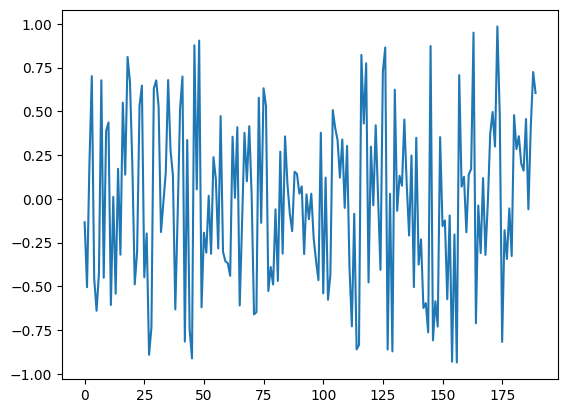

In [14]:
from matplotlib import pyplot as plt

plt.plot(sims)

In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertConfig, BertModel, AutoTokenizer
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def global_ap(x):
    return torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)

class SimSonEncoder(nn.Module):
    def __init__(self, config: BertConfig, max_len: int, dropout: float = 0.1):
        super(SimSonEncoder, self).__init__()
        self.config = config
        self.max_len = max_len
        
        self.bert = BertModel(config, add_pooling_layer=False)
        
        self.linear = nn.Linear(config.hidden_size, max_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask=None):
        if attention_mask is None:
            attention_mask = input_ids.ne(0)
            
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        hidden_states = outputs.last_hidden_state
        
        hidden_states = self.dropout(hidden_states)
        
        pooled = global_ap(hidden_states)
        
        out = self.linear(pooled)
        
        return out

def initialize_model_and_tokenizer():
    """Initialize BERT model from config and ChemBERTa tokenizer"""
    
    
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
    config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=4,
        num_attention_heads=12,
        intermediate_size=2048,
        max_position_embeddings=512,
    )
    model = SimSonEncoder(config=config, max_len=512).cuda()
    return model, tokenizer


In [16]:
import time


class MolecularContrastiveDataset(Dataset):
    def __init__(self, data_list, tokenizer, positive_threshold=0.9, cache_path=None, split_type='train'):
        """
        Dataset that only contains positive pairs for NT-Xent contrastive learning
        """
        self.data_list = data_list
        self.tokenizer = tokenizer
        self.positive_threshold = positive_threshold
        self.cache_path = cache_path
        self.split_type = split_type

        # Load or compute pairs
        if cache_path and os.path.exists(cache_path) and os.path.getsize(cache_path) > 0:
            print(f"Loading cached pairs from {cache_path}")
            self._load_pairs()
        else:
            print("Computing positive pairs only...")
            self._compute_positive_pairs()
            if cache_path:
                self._save_pairs()
    
    def _compute_positive_pairs(self):
        """
        Compute ONLY positive pairs based on descriptor similarity
        """
        # --- 1. Cosine-similarity matrix ---------------------------------------
        prop_vectors = torch.stack(
            [item['property_tensor'] for item in self.data_list]
        ).numpy()
        sim_matrix = cosine_similarity(prop_vectors)

        n = len(self.data_list)
        positive_pairs = []
        pairs_per_molecule = 1 # STRICTLY ONE FOR CREATING PROPER NEGATIVE PAIRS
        current_pairs_per_molecule = 0
        # --- 2. Collect only positive pairs ------------------------------------
        print(f'Collecting positive pairs with similarity threshold {self.positive_threshold}')
        for i in tqdm(range(n)):
            for j in range(i + 1, n):
                sim = sim_matrix[i, j]
                if sim > self.positive_threshold:
                    positive_pairs.append((i, j, sim))
                    current_pairs_per_molecule += 1
                if current_pairs_per_molecule > pairs_per_molecule:
                    current_pairs_per_molecule = 0
                    break

        # --- 3. Store only positive pairs --------------------------------------
        if len(positive_pairs) == 0:
            raise ValueError("No positive pairs found – lower the positive_threshold.")

        # No shuffling - we want consistent positive pairs
        self.pairs = [(i, j) for i, j, _ in positive_pairs]
        self.descriptor_similarities = [sim for _, _, sim in positive_pairs]

        print(f"Generated {len(self.pairs)} positive pairs")

    def _save_pairs(self):
        """Save computed pairs to cache file"""
        cache_data = {
            'pairs': self.pairs,
            'descriptor_similarities': self.descriptor_similarities
        }
        with open(self.cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cached pairs saved to {self.cache_path}")
    
    def _load_pairs(self):
        """Load pairs from cache file"""
        with open(self.cache_path, 'rb') as f:
            cache_data = pickle.load(f)
        
        self.pairs = cache_data['pairs']
        self.descriptor_similarities = cache_data['descriptor_similarities']
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        desc_sim = self.descriptor_similarities[idx]
        
        # Get SMILES for both molecules
        smiles_i = self.data_list[i]['Smiles']
        smiles_j = self.data_list[j]['Smiles']
        if self.split_type == 'val':
            print(f'POSITIVE PAIR SMILES: \n{smiles_i} \n {smiles_j}')
        # Tokenize SMILES
        tokens_i = self.tokenizer(
            smiles_i, 
            return_tensors='pt', 
            padding='max_length', 
            truncation=True, 
            max_length=256
        )
        tokens_j = self.tokenizer(
            smiles_j, 
            return_tensors='pt', 
            padding='max_length', 
            truncation=True, 
            max_length=256
        )
        
        # Remove batch dimension
        tokens_i = {key: val.squeeze(0) for key, val in tokens_i.items()}
        tokens_j = {key: val.squeeze(0) for key, val in tokens_j.items()}
        
        # Get property vectors
        prop_vec_i = self.data_list[i]['property_tensor']
        prop_vec_j = self.data_list[j]['property_tensor']
        
        return {
            'tokens_i': tokens_i,
            'tokens_j': tokens_j,
            'descriptor_similarity': torch.tensor(desc_sim, dtype=torch.float32),
            'property_tensor_i': prop_vec_i,
            'property_tensor_j': prop_vec_j
        }


def contrastive_collate_fn(batch):
    """
    Collate function that creates proper NT-Xent batches:
    - Element 0 and 1 are positive pairs
    - Element 2 and 3 are positive pairs  
    - etc.
    """
    batch_size = len(batch)
    
    # Ensure even batch size for proper pairing
    if batch_size % 2 != 0:
        batch = batch[:-1]  # Drop last element if odd
        batch_size = len(batch)
    
    # Interleave: [sample1_i, sample1_j, sample2_i, sample2_j, ...]
    tokens_list = []
    desc_similarities = []
    
    for i in range(0, batch_size, 1):
        # Add first molecule of pair i
        tokens_list.append(batch[i]['tokens_i'])
        desc_similarities.append(batch[i]['descriptor_similarity'])
        
        # Add second molecule of pair i (positive pair)
        tokens_list.append(batch[i]['tokens_j'])
        desc_similarities.append(batch[i]['descriptor_similarity'])  # Same similarity for both elements in pair
    
    # Stack all tokens
    tokens = {}
    for key in tokens_list[0].keys():
        tokens[key] = torch.stack([item[key] for item in tokens_list])
    
    desc_similarities_tensor = torch.stack(desc_similarities)
    
    return {
        'tokens': tokens,
        'descriptor_similarities': desc_similarities_tensor,
    }


def create_dataloaders(train_list, val_list, tokenizer, batch_size=32, 
                      positive_threshold=0.85, cache_dir="cache"):
    """Create train and validation dataloaders for NT-Xent"""
    os.makedirs(cache_dir, exist_ok=True)
    
    # Ensure even batch size for proper pairing
    if batch_size % 2 != 0:
        batch_size += 1
        print(f"Adjusted batch_size to {batch_size} (must be even for NT-Xent)")
    
    train_cache = os.path.join(cache_dir, 'train_positive_pairs.pkl')
    val_cache = os.path.join(cache_dir, 'val_positive_pairs.pkl')
    
    train_dataset = MolecularContrastiveDataset(
        train_list, tokenizer, positive_threshold=positive_threshold, cache_path=train_cache
    )
    val_dataset = MolecularContrastiveDataset(
        val_list, tokenizer, positive_threshold=positive_threshold, cache_path=val_cache, split_type='val',
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=contrastive_collate_fn, drop_last=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=contrastive_collate_fn, drop_last=True, pin_memory=True
    )
    
    return train_loader, val_loader



In [17]:
def nt_xent_loss_with_temp_scaling(embeddings1, embeddings2, descriptor_similarity, base_temp=0.02):
    batch_size = embeddings1.shape[0]
    device = embeddings1.device
    #individual_temperatures = sigmoid_temp_scaling(descriptor_similarity, base_temp)
    #temperature = individual_temperatures.mean() # Single temperature for the whole batch
    temperature = base_temp
    # Normalize projections
    z_i = F.normalize(embeddings1, p=2, dim=1)
    z_j = F.normalize(embeddings2, p=2, dim=1)
    
    # Concatenate for similarity matrix calculation
    representations = torch.cat([z_i, z_j], dim=0)
    # Calculate cosine similarity between all pairs
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
    #similarity_matrix = torch.clamp(similarity_matrix, min=-0.999, max=0.999)
    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)
    positives = torch.cat([sim_ij, sim_ji], dim=0)
    
    # Create a mask to exclude self-comparisons
    nominator = torch.exp(positives / temperature)
    mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=torch.bool, device=device)).float()
    denominator = mask * torch.exp(similarity_matrix / temperature)
    
    # Calculate the final loss
    loss = -torch.log(nominator / torch.sum(denominator, dim=1))
    if torch.isnan(loss).any():
        print(similarity_matrix)
        print(f"Temperature: {temperature}")
        print(f"Nominator range: {nominator.min().item():.6f} to {nominator.max().item():.6f}")
        
    return torch.sum(loss) / (2 * batch_size)


def sigmoid_temp_scaling(descriptor_similarity, base_temp=0.05, steepness=10.0, midpoint=0.5):
    """Smooth sigmoid-based temperature scaling"""
    sigmoid_factor = torch.sigmoid(steepness * (descriptor_similarity - midpoint))
    temperature = base_temp * (2.0 - sigmoid_factor)
    return temperature


def train_step(batch, model, optimizer, device, scheduler, base_temp=0.1):
    """Single training step for NT-Xent"""
    model.train()
    optimizer.zero_grad()
    
    # Move batch to device
    tokens = {k: v.to(device) for k, v in batch['tokens'].items()}
    desc_similarities = batch['descriptor_similarities'].to(device)
    
    # Forward pass - get embeddings for all samples
    outputs = model(**tokens) # i1, j1, i2, j2 ...
    embeddings = outputs
    
    # Split embeddings: even indices are embeddings1, odd indices are embeddings2
    embeddings1 = embeddings[::2]  # [0, 2, 4, ...]
    embeddings2 = embeddings[1::2] # [1, 3, 5, ...]
    
    # Get descriptor similarities for each pair (take every other one since they're duplicated)
    pair_desc_similarities = desc_similarities[::2]
    #print(f'FIRST TRAIN EMBED: {embeddings1}')
    #print(f'SECOND TRAIN EMBED: {embeddings2}')
    #print(f'COSINE SIM BETWEEN THEM TRAIN: {F.cosine_similarity(embeddings1, embeddings2, dim=1)}')
    # Calculate NT-Xent loss
    loss = nt_xent_loss_with_temp_scaling(embeddings1, embeddings2, pair_desc_similarities, base_temp=base_temp)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scheduler.step()
    return loss.item()

def val_step(batch, model, device, base_temp=0.1):
    """Single validation step for NT-Xent"""
    model.eval()
    with torch.no_grad():
        # Move batch to device
        tokens = {k: v.to(device) for k, v in batch['tokens'].items()}
        desc_similarities = batch['descriptor_similarities'].to(device)
        
        # Forward pass
        outputs = model(**tokens)
        embeddings = outputs
        
        # Split embeddings
        embeddings1 = embeddings[::2]
        embeddings2 = embeddings[1::2]
        
        # Get descriptor similarities for pairs
        pair_desc_similarities = desc_similarities[::2]
        
        print(f'FIRST VAL EMBED: {embeddings1}')
        print(f'SECOND VAL EMBED: {embeddings2}')
        print(f'COSINE SIM BETWEEN THEM: {F.cosine_similarity(embeddings1, embeddings2, dim=1)}')
        #print(f'SECOND VAL EMBED: {embeddings2}')
        loss = nt_xent_loss_with_temp_scaling(embeddings1, embeddings2, pair_desc_similarities, base_temp=base_temp)
        print(f'VAL LOSS: {loss}')
    
    return loss.item()

def train_epoch(train_loader, model, optimizer, scheduler, base_temp=0.01):
    """Train for one epoch"""
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch in progress_bar:
        loss = train_step(batch, model, optimizer, 'cuda', scheduler, base_temp=base_temp)
        total_loss += loss
        num_batches += 1
        
        # Calculate running average loss
        avg_loss = total_loss / num_batches
        
        # Update progress bar with current loss info
        progress_bar.set_postfix({
            'Loss': f'{loss:.4f}',
            'Avg Loss': f'{avg_loss:.4f}'
        })
    
    return total_loss / num_batches if num_batches > 0 else 0


def validate_epoch(val_loader, model, base_temp=0.01):
    """Validate for one epoch"""
    total_loss = 0
    num_batches = 0
    print('nah twin')
    return 0
    for batch in val_loader:
        loss = val_step(batch, model, 'cuda', base_temp=base_temp)
        total_loss += loss
        num_batches += 1
    
    return total_loss / num_batches if num_batches > 0 else 0

def training_loop(train_loader, val_loader, model, tokenizer, epochs=50, patience=5, lr=1e-4, base_temp=0.02,
                 device_name='cuda', save_path='best_model.pt'):
    """Main training loop with early stopping"""
    device = torch.device(device_name if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize model and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()

    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_mult=1, T_0=total_steps)
    # Early stopping variables
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training
        with torch.autocast(dtype=torch.float16, device_type='cuda'):
            train_loss = train_epoch(train_loader, model, optimizer, scheduler, base_temp=base_temp)
            print('END TRAIN')
            # Validation
            val_loss = validate_epoch(val_loader, model)
        
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            # Save best model
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with val loss: {val_loss:.4f}")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs")
        
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
    
    # Load best model
    print(f"Loading best model from {save_path}")
    model.load_state_dict(torch.load(save_path))
    model.eval()
    
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")


model, tokenizer = initialize_model_and_tokenizer()
#model.load_state_dict(torch.load('/home/jovyan/simson_training_bolgov/regression/actual_encoder_state.pkl', weights_only=False))
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


Model initialized with 23,299,840 trainable parameters


In [18]:
!rm -rf cache

In [ ]:
train_loader, val_loader = create_dataloaders(
    train_list, val_list[:100], tokenizer, 
    batch_size=128, positive_threshold=0.8
)

training_loop(
    train_loader, val_loader, model, tokenizer,
    epochs=10, patience=5, lr=1e-3, 
    device_name='cuda', base_temp=0.1
)


Computing positive pairs only...


100%|████████████████████████████████████| 6378/6378 [00:00<00:00, 55896.48it/s]


Generated 12538 positive pairs
Cached pairs saved to cache/train_positive_pairs.pkl
Computing positive pairs only...


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 206209.64it/s]


Generated 129 positive pairs
Cached pairs saved to cache/val_positive_pairs.pkl
Using device: cuda
Starting training...


Training: 100%|█| 1567/1567 [00:31<00:00, 49.37it/s, Loss=0.9300, Avg Loss=0.989


END TRAIN
nah twin
Epoch 1/10: Train Loss = 0.9891, Val Loss = 0.0000
New best model saved with val loss: 0.0000


Training: 100%|█| 1567/1567 [00:31<00:00, 50.05it/s, Loss=2.7072, Avg Loss=2.712


END TRAIN
nah twin
Epoch 2/10: Train Loss = 2.7125, Val Loss = 0.0000
No improvement for 1 epochs


Training:  77%|▊| 1204/1567 [00:24<00:07, 49.73it/s, Loss=2.7080, Avg Loss=2.708

In [ ]:
print(train_list[:5], '\n\n', val_list[:5])